# 01: Linear Least Squares Regression

Say you want to predict a $y$ value given some $x$ value. For instance, maybe we want to predict the value of a skyscraper building (our $y$ value, measured in dollars) from its height (our $x$ value, in meters).

What we want is a function $f$ that takes in an $x$ and outputs a $y$. For instance, if we want to predict the value of a 100 meter tall building, we would calculate $f(100)$. In the context of machine learning, we call this the *model*.

There are all sorts of functions that $f$ could be: linear, quadratic, exponential, logarithmic. But in machine learning, we typically restrict the models under consideration to a *model class* (also called a *model family*): functions that fit a standard format. For this notebook, we'll only look at *linear* models: $f(x) = \theta_0 + \theta_1 x$.

*Regression* is the task of choosing a model to predict a real value $y$ from an input value $x$ (also typically a real value, but not necessarily). As a reminder: a *real number* could be $100$ or $37.54$ or $\pi$. Regression is in contrast to *classification*, which is the prediction of a *class* $y$ from an input value $x$. For instance, a class could be "Picture of a cat" or "Picture of a dog." We'll talk about regression next lecture.

*Linear* regression is a regression problem where we only consider lines as possible models. How will we choose which line? To do so, we will first need to use *training* data. Training data are previously observed pairs of $x$s and $y$s. We normally denote the $i$th of $N$ training datapoint like so: $(x_i, y_i)$.

How will we use the training data to pick a linear model? Well, a model that can predict skyscraper values in the future should also be able to have predicted skyscraper prices in the past. So the ideal is to pick a line that goes through the observed $(x_i, y_i)$ training set values.

To start making this real, let's generate some training data and graph it.

x shape: (100,)
y shape: (100,)


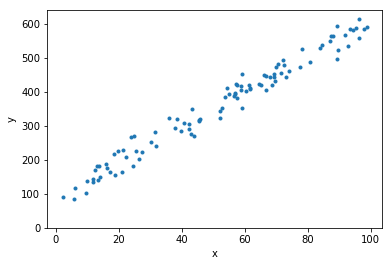

In [1]:
%matplotlib inline

from lib.dataset import DATASET
from examples import generate_data_example

generate_data_example.run(DATASET)

The `DataSet` class has a true `THETA0` and a true `THETA1`: we'll pretend we don't know those. Our goal is to *learn* them. In the `generate_data` method, I *uniformly* sample $x$ values in the range $[0, 100]$. That means that the probability that a sampled $x$ value lands in some range $(a, b)$ is always proportional to the range's *width*: $b - a$. Put another way: the $x$ values should be spread evenly throughout the overall range $[0, 100]$.

I then calculate the "true" $y$ value using the equation $y = \theta_0 + \theta_1 x$. If I graphed the "true" $y$ values, then they would all lie perfectly on that line.

### Normal Distribution of Noise
However, I also generate *noise*, which is random variation that cannot be guessed from the $x$ value. I then add this noise into the $y$ value.

Why add this noise? In real life, an output value like $y$ will be a function of many, many factors. We are only using one factor ($x$, the height of the skyscraper). We are ignoring all the other factors.

Some of those factors could be "truly" random (as in, at the quantum mechanics level). But most factors probably act in a deterministic way, except that we haven't measured those factors, so we can't account for them. For instance, it is relevant *where* the building is to how much it is *worth*. In fact, in real life we wouldn't expect to be able to predict a skyscraper's price very well at all without knowledge of where it is.

Since we don't know the skyscrapers' locations, we cannot account for its impact on the value of a skyscraper. The effect of unmeasured factors (like location in this instance) thus looks like *noise*: random variation that makes it so that no line perfectly fits the data.

When generating noise, I sample from a *normal distribution*, also called a *Gaussian distribution*. The shape of this kind of distribution is the *bell curve*.

The [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) says that the effect of many small factors will be will approximated by a normal distribution. (There are many technical assumptions that need to apply, but we will ignore those). The key thing about the central limit theorem is that it doesn't matter *how* the factors effect the result (linear, quadratic, exponential, whatever), so long as there are many of them and they are small.

(Note: the proof of the Central Limit Theorem is pretty technical. We don't need to prove it to use it.)

An example: human height tends to be distributed in a bell curve shape because it is the result of many small factors.

It is therefore natural to generate noise that is normally distributed. My assumption is that there are many unaccounted for factors that effect skyscraper value. I don't know how any one of those factors effects skyscraper value, but the Central Limit Theorem says that, in aggregate, the effect is normally distributed.

Because the noise is a result from factors other than $x$, it is theoretically impossible to perfectly predict $y$ from $x$. Therefore our goal is to do the best we can, and try to discover that part of the skyscrapper value which *is* predictable from the height.

### Sum of Squared Errors

So we want to learn how to best predict the $y$ values using the $x$ value, knowing that this is only a "best guess," and that there will still be some variation in the $y$ value. How do we use the observed $(x_i, y_i)$ training data to do this?

Since no line can never perfectly pass through the datapoints, our goal will be to pick a line $f$ where $f(x_i)$ is as close as possible to $y_i$ for each of the training datapoints $(x_i, y_i)$. We call the difference $f(x_i) - y_i$ the *error* of the model $f$ at training datapoint $(x_i, y_i)$. What we want to do is *minimize* the *overall sum* of $|f(x_i) - y_i|$ across all the datapoints. The reason we take the absolute value is because both underestimates and overestimates of $f(x_i)$ contribute positively to the overall error. Therefore, we want to minimize the *sum of absolute errors*. Let me write that out:

\\[
AbsErr(\hat\theta_0, \hat\theta_1) 
= \sum_{i = 0}^N \left|\hat{y}_i - y_i\right|
= \sum_{i = 0}^N \left|f_{\hat\theta_0, \hat\theta_1}(x_i) - y_i\right|
= \sum_{i = 0}^N \left|(\hat\theta_0 + \hat\theta_1 x_i) - y_i\right|
\\]

Here, I've used $\hat\theta_0, \hat\theta_1$ to represent our *estimates* of the true values of $\theta_0, \theta_1$. We put a "hat" on any quantity that is an estimate: for instance $\hat{y}_i$ is our estimate of $y_i$ using the model. The function $f_{\hat\theta_0, \hat\theta_1}$ is just the line $\hat\theta_0 + \hat\theta_1 x$. However, I will typically leave out the subscript of $f$ when it won't cause confusion.

Since every linear model $f$ can be written as $f_{\theta_0, \theta_1}$ for some $\theta_0, \theta_1$, we sometimes say that the class of linear models is *parameterized* by the *parameters* $\hat\theta_0$.

There is a more common choice of error function called the *squared error* or the *sum of squared errors*. This is abbreviated *SSE* commonly. Here is how we define it:

\\[
SSE(\hat\theta_0, \hat\theta_1) 
= \sum_{i = 0}^N \left( \hat{y}_i - y_i \right)^2
= \sum_{i = 0}^N \left( f_{\hat\theta_0, \hat\theta_1}(x_i) - y_i \right)^2
= \sum_{i = 0}^N \left( \left( \hat\theta_0 + \hat\theta_1 x_i \right) - y_i \right)^2
\\]

This is the same as the absolute error, except we square the errors. We don't need the absolute value sign anymore because an error squared is always positive.

Why use squared errors rather than absolute errors? I will show you later: it turns out that using the squared errors is the right choice if we think the noise is normally distributed.

### Calculating the SSE

Now, let's plot a line through the data. We'll plot the "true" model line $\theta_0 + \theta_1 x$. We'll also graph the errors and find the SSE. Note that I report the *average* squared error. The average squared error is often nice to use, because it is insensitive to the number of examples in the dataset.

Average Squared Error: 596.33


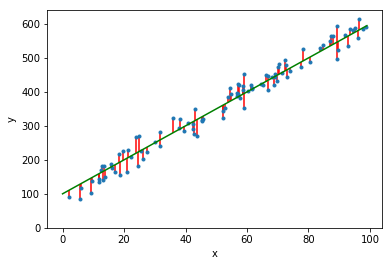

In [2]:
from examples import true_model_example

true_model_example.run(DATASET)

As a quick check, we can take the square root of the average squared error: $\sqrt{596.33} = 24.41$. That is roughly the "average" error. (Technically the square root of the average square can be a little different from the average.) Anyway $24.41$ looks about right for the average error. Not so bad! And isn't it fascinating how close that is to `NOISE_STDDEV`, which is $25$? Hmmm... We'll return to that later.

Notice that even the *true* model has some squared error. That's because the noise from the other, unaccounted for factors means you can't perfectly predict $y_i$ from just $x_i$.

### Learning Model Parameters

Let's start trying to find the best model of the dataset, and pretend that we don't know the true $\theta_0, \theta_1$. We want to pick values $\hat\theta_0, \hat\theta_1$ such that the SSE is minimized. That is, we want to minimize:

\\[
\sum_{i = 0}^N \left( \left( \hat\theta_0 + \hat\theta_1 x_i \right) - y_i \right)^2
\\]

If you treat $y_i$ and $x_i$ as constants, this is a quadratic polynomial in $\hat\theta_0, \hat\theta_1$. Polynomials are always *differentiable*, which means that their minima/maxima are always at locations where the derivative is zero. That is, at points where both:

\\[
\begin{alignat*}{3}
\frac{\partial E}{\partial \hat\theta_0} &= \sum_{i=1}^N 2 \left(
                                              \left( \hat\theta_0 + \hat\theta_1 x_i \right) - y_i
                                            \right) \big(1\big) &&= 0\\
\frac{\partial E}{\partial \hat\theta_1} &= \sum_{i=1}^N 2 \left(
                                              \left( \hat\theta_0 + \hat\theta_1 x_i \right) - y_i
                                            \right) \big( x_i \big) &&= 0\\
\end{alignat*}
\\]

Notice how I used the chain rule! In fact we know that the sum of squared errors is an always positive quadratic function. An always positive quadratic function always has a single minimum value at precisely the $\hat\theta_0, \hat\theta_1$ that satisfies these equations!

